<a href="https://colab.research.google.com/github/Aarush-Aggarwal/Kaggle/blob/main/Financial_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imported Libraries (linear algebra, plotting, data processing, CSV file I/O, etc.)
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from   sklearn.manifold import TSNE
from   sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import collections
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Other Libraries (model, pipeline, metrics, etc.)
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('drive/MyDrive/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [3]:
# Checking for the Null Values
df.isnull().sum().max()

0

In [4]:
# Checking for the amount of skewed classes
print('No Frauds: ', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds: ', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset


# Plotting : Class Distribution

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

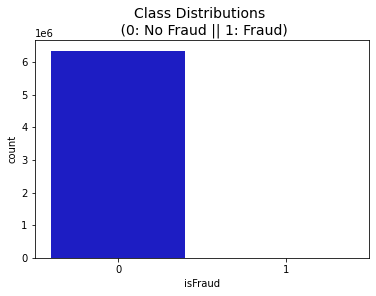

In [5]:
# plot of class distribution (Non-Fraud vs Fraud)
colors = ["#0101DF", "#DF0101"]
sns.countplot('isFraud', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

# Plotting : Distribution of the Data (Features)

(0.0, 356179278.92)

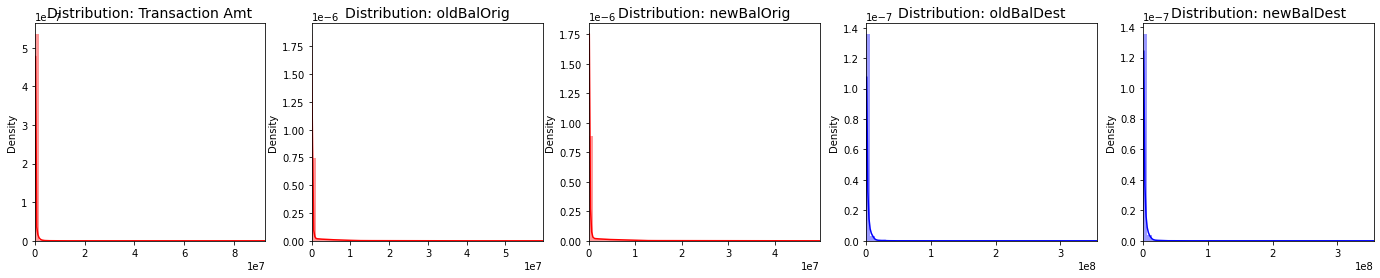

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(24,4))

amount_val         = df['amount'].values
oldBalanceOrig_val = df['oldbalanceOrg'].values
newBalanceOrig_val = df['newbalanceOrig'].values
oldBalanceDest_val = df['oldbalanceDest'].values
newBalanceDest_val = df['newbalanceDest'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution: Transaction Amt', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(oldBalanceOrig_val, ax=ax[1], color='r')
ax[1].set_title('Distribution: oldBalOrig', fontsize=14)
ax[1].set_xlim([min(oldBalanceOrig_val), max(oldBalanceOrig_val)])

sns.distplot(newBalanceOrig_val, ax=ax[2], color='r')
ax[2].set_title('Distribution: newBalOrig', fontsize=14)
ax[2].set_xlim([min(newBalanceOrig_val), max(newBalanceOrig_val)])

sns.distplot(oldBalanceDest_val, ax=ax[3], color='b')
ax[3].set_title('Distribution: oldBalDest', fontsize=14)
ax[3].set_xlim([min(oldBalanceDest_val), max(oldBalanceDest_val)])

sns.distplot(newBalanceDest_val, ax=ax[4], color='b')
ax[4].set_title('Distribution: newBalDest', fontsize=14)
ax[4].set_xlim([min(newBalanceDest_val), max(newBalanceDest_val)])

**Note**: Considering the above distribution of features, *Feature Scaling* is required

# Scaling the Data (Features)

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount']     = rob_scaler.fit_transform(df['amount'].values.reshape(-1,1))
df['scaled_oldBalOrig'] = rob_scaler.fit_transform(df['oldbalanceOrg'].values.reshape(-1,1))
df['scaled_newBalOrig'] = rob_scaler.fit_transform(df['newbalanceOrig'].values.reshape(-1,1))
df['scaled_oldBalDest'] = rob_scaler.fit_transform(df['oldbalanceDest'].values.reshape(-1,1))
df['scaled_newBalDest'] = rob_scaler.fit_transform(df['newbalanceDest'].values.reshape(-1,1))

# amount
df.drop('amount', axis=1, inplace=True)
scaled_amount = df['scaled_amount']
df.drop('scaled_amount', axis=1, inplace=True)
df.insert(3, 'scaled_amount', scaled_amount)

# old balance origin
df.drop('oldbalanceOrg', axis=1, inplace=True)
scaled_oldBalOrig = df['scaled_oldBalOrig']
df.drop('scaled_oldBalOrig', axis=1, inplace=True)
df.insert(4, 'scaled_oldBalOrig', scaled_oldBalOrig)

# new balance origin
df.drop('newbalanceOrig', axis=1, inplace=True)
scaled_newBalOrig = df['scaled_newBalOrig']
df.drop('scaled_newBalOrig', axis=1, inplace=True)
df.insert(5, 'scaled_newBalOrig', scaled_newBalOrig)

# old balance destination
df.drop('oldbalanceDest', axis=1, inplace=True)
scaled_oldBalDest = df['scaled_oldBalDest']
df.drop('scaled_oldBalDest', axis=1, inplace=True)
df.insert(6, 'scaled_oldBalDest', scaled_oldBalDest)

# new balance destination
df.drop('newbalanceDest', axis=1, inplace=True)
scaled_newBalDest = df['scaled_newBalDest']
df.drop('scaled_newBalDest', axis=1, inplace=True)
df.insert(7, 'scaled_newBalDest', scaled_newBalDest)

# Splitting the Data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# Dropping the features not contributing much to the variance/result
X = df.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# "original_" is used because we already have X_train and y_train for undersample data, so to distinguish to avoid overwriting the variables
for train_index, test_index in skf.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Checking the Distribution of the labels
# Turning into an array
original_Xtrain = original_Xtrain.values
original_Xtest  = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest  = original_ytest.values

# checking if both the train and test label distributions are "similarly" distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset
Train: [1272422 1272423 1272424 ... 6362617 6362618 6362619] Test: [      0       1       2 ... 1510291 1510292 1510293]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [1272422 1272423 1272424 ... 3958614 3958615 3958622]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [2544062 2544063 2544064 ... 6009078 6009346 6009347]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [3815834 3815835 3815836 ... 6243165 6243166 6243645]
Train: [      0       1       2 ... 6243165 6243166 6243645] Test: [5087485 5087486 5087487 ... 6362617 6362618 6362619]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99870926 0.00129074]
[0.99870887 0.00129113]


In [10]:
# Since our classes are highly skewed, need to make them equivalent in order to have a normal distribution of the classes.

# shuffle the data before creating the subsamples

# df.sample(frac=1) does not create new memory object though reference object changes i.e. id(df) changes but not the underlying C object
# df = df.sample(frac=1).reset_index(drop=True) # drop=True prevents .reset_index() from creating a column containing the old index entries
df = df.sample(frac=1) # if passed the argument "random_state=42", it makes sure that random choice is always replicatable

# only number equal to fraud classes is taken for both fraud df as well as non-fraud df
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0][:df.isFraud.value_counts()[1]]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,step,type,nameOrig,scaled_amount,scaled_oldBalOrig,scaled_newBalOrig,scaled_oldBalDest,scaled_newBalDest,nameDest,isFraud,isFlaggedFraud
1635588,157,CASH_OUT,C250239974,-0.321508,-0.132395,0.0,0.110634,0.030980,C1494859130,0,0
6227109,591,CASH_OUT,C1552349375,-0.224095,-0.132395,0.0,0.154311,0.085137,C1218061488,0,0
1343287,137,TRANSFER,C984621443,4.791769,9.287124,0.0,-0.140722,-0.193057,C1664913171,1,0
2526209,205,CASH_OUT,C1018733794,0.581580,1.623863,0.0,0.081631,0.165030,C802139688,1,0
6207688,587,TRANSFER,C684914427,1.092456,2.553743,0.0,-0.140722,-0.193057,C1298141757,1,0


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: isFraud, dtype: float64


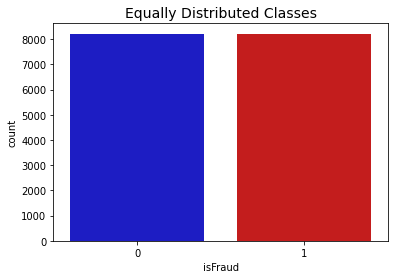

In [11]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['isFraud'].value_counts()/len(new_df))

sns.countplot('isFraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

# Correlation Matrices

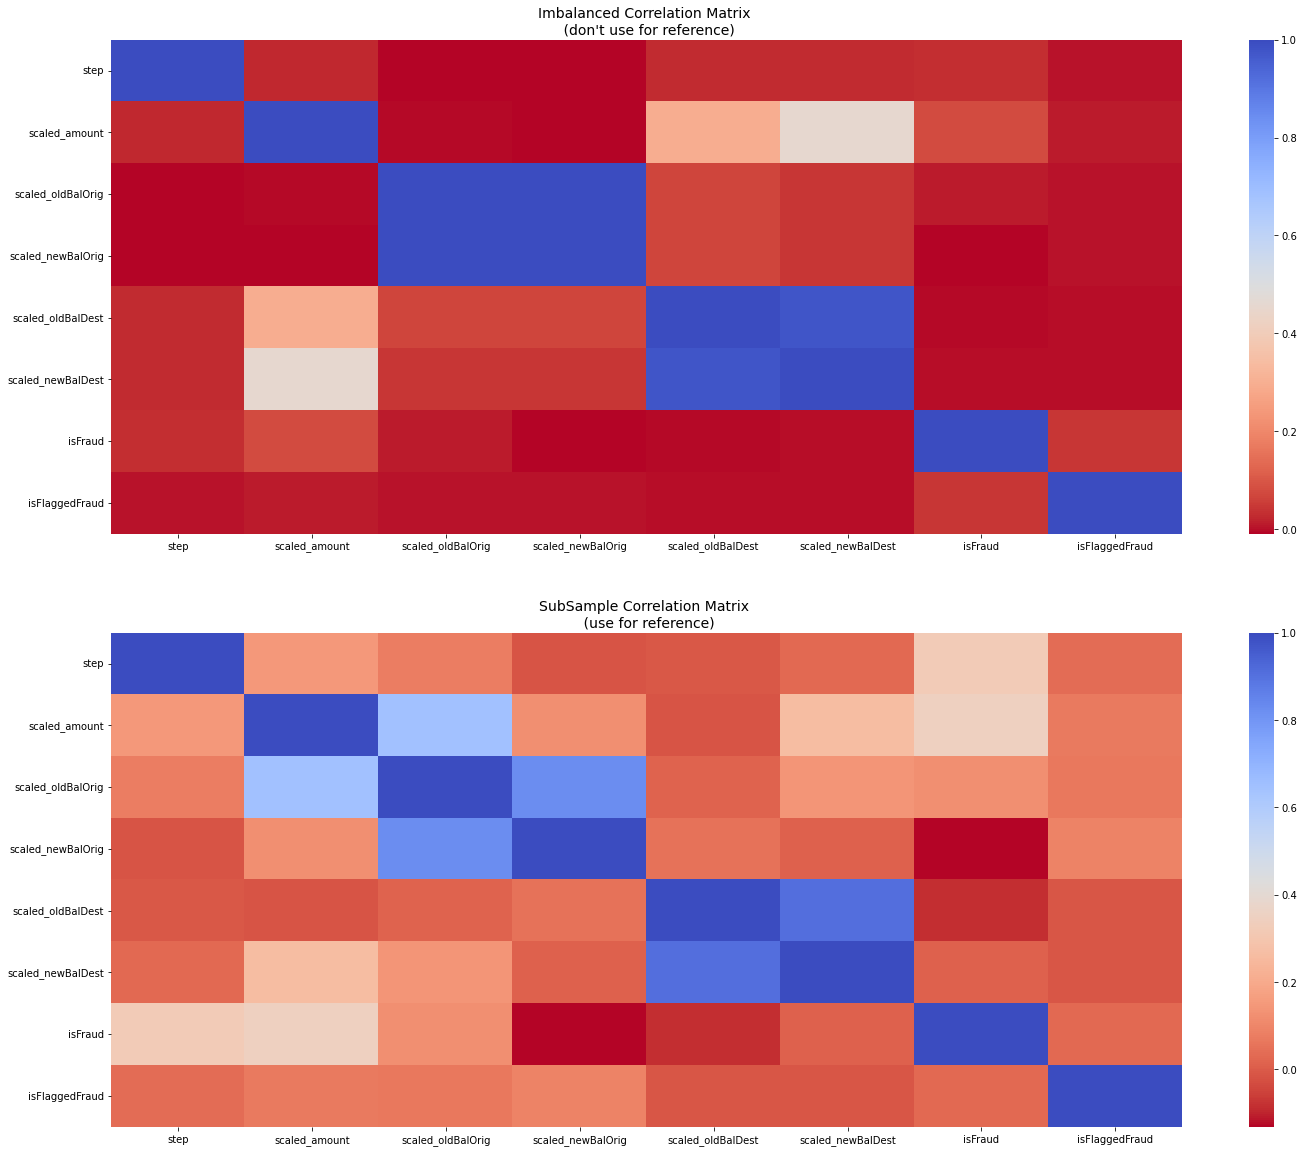

In [12]:
# making sure to use the subsample in our correlation
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# df.corr() calculates the correlation matrix whose elements range is [-1, 1], by default it uses Pearson Correlation coefficient. 
# sns.heatmap is used to display using colors how strong the correlations are
# It's just a way to see the correlations with colors instead of a number so the user can identify which variables are more correlated.

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Subsampled DataFrame
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

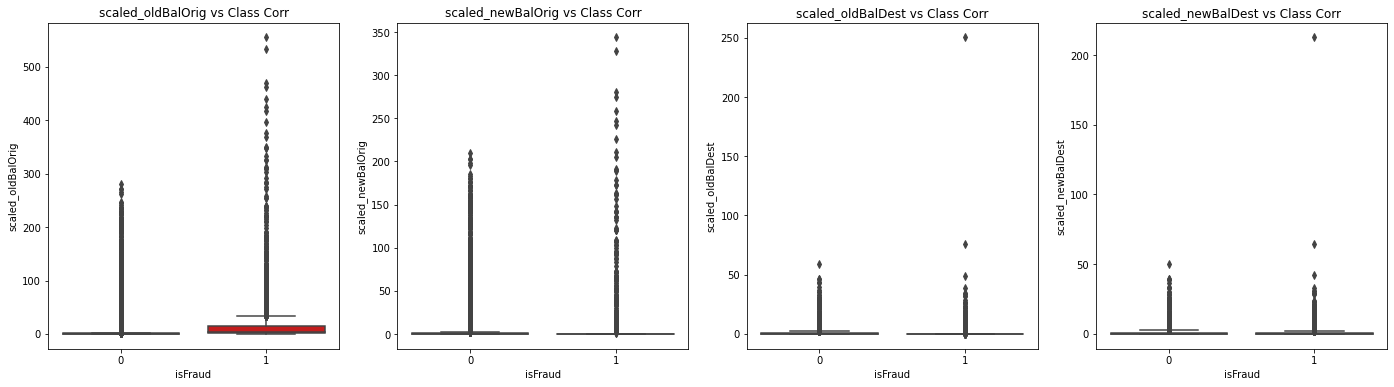

In [13]:
f, axes = plt.subplots(ncols=4, figsize=(24,6))

# Correlations with the Class isFraud (The lower our feature value, the more likely it will be a fraud transaction)

sns.boxplot(x="isFraud", y="scaled_oldBalOrig", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('scaled_oldBalOrig vs Class Corr')

sns.boxplot(x="isFraud", y="scaled_newBalOrig", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('scaled_newBalOrig vs Class Corr')


sns.boxplot(x="isFraud", y="scaled_oldBalDest", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('scaled_oldBalDest vs Class Corr')


sns.boxplot(x="isFraud", y="scaled_newBalDest", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('scaled_newBalDest vs Class Corr')


plt.show()

# Anomaly Detection:

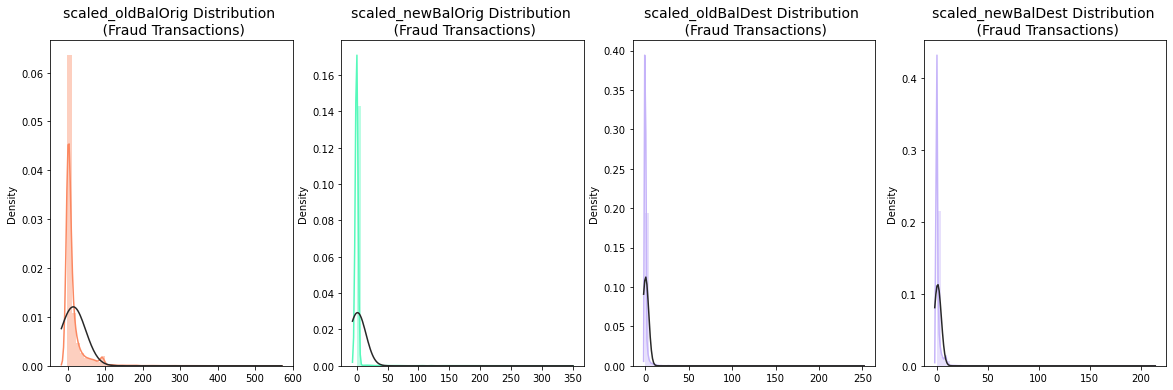

In [14]:
from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

oldBalOrig_fraud_dist = new_df['scaled_oldBalOrig'].loc[new_df['isFraud'] == 1].values
sns.distplot(oldBalOrig_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('scaled_oldBalOrig Distribution \n (Fraud Transactions)', fontsize=14)

newBalOrig_fraud_dist = new_df['scaled_newBalOrig'].loc[new_df['isFraud'] == 1].values
sns.distplot(newBalOrig_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('scaled_newBalOrig Distribution \n (Fraud Transactions)', fontsize=14)

oldBalDest_fraud_dist = new_df['scaled_oldBalDest'].loc[new_df['isFraud'] == 1].values
sns.distplot(oldBalDest_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('scaled_oldBalDest Distribution \n (Fraud Transactions)', fontsize=14)

newBalDest_fraud_dist = new_df['scaled_newBalDest'].loc[new_df['isFraud'] == 1].values
sns.distplot(newBalDest_fraud_dist,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('scaled_newBalDest Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

In [15]:
# IQR (Inter-Quartile Range) method is used along with box-whishker plots. Also, (1.5 * IQR) is the threshold value used for outliers
# removing Outliers for scaled_oldBalOrig 
oldBalOrig_fraud = new_df['scaled_oldBalOrig'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(oldBalOrig_fraud, 25), np.percentile(oldBalOrig_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
oldBalOrig_iqr = q75 - q25
print('iqr: {}'.format(oldBalOrig_iqr))

oldBalOrig_cut_off = oldBalOrig_iqr * 1.5
oldBalOrig_lower, oldBalOrig_upper = q25 - oldBalOrig_cut_off, q75 + oldBalOrig_cut_off
print('Cut Off: {}'.format(oldBalOrig_cut_off))
print('oldBalOrig Lower: {}'.format(oldBalOrig_lower))
print('oldBalOrig Upper: {}'.format(oldBalOrig_upper))

outliers = [x for x in oldBalOrig_fraud if x < oldBalOrig_lower or x > oldBalOrig_upper]
print('Feature oldBalOrig Outliers for Fraud Cases: {}'.format(len(outliers)))
print('oldBalOrig outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['scaled_oldBalOrig'] > oldBalOrig_upper) | (new_df['scaled_oldBalOrig'] < oldBalOrig_lower)].index)
print('----' * 40)


# scaled_newBalOrig, removing outliers from fraud transactions
newBalOrig_fraud = new_df['scaled_newBalOrig'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(newBalOrig_fraud, 25), np.percentile(newBalOrig_fraud, 75)
newBalOrig_iqr = q75 - q25

newBalOrig_cut_off = newBalOrig_iqr * 1.5
newBalOrig_lower, newBalOrig_upper = q25 - newBalOrig_cut_off, q75 + newBalOrig_cut_off
print('newBalOrig Lower: {}'.format(newBalOrig_lower))
print('newBalOrig Upper: {}'.format(newBalOrig_upper))
outliers = [x for x in newBalOrig_fraud if x < newBalOrig_lower or x > newBalOrig_upper]
print('newBalOrig outliers: {}'.format(outliers))
print('Feature newBalOrig Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['scaled_newBalOrig'] > newBalOrig_upper) | (new_df['scaled_newBalOrig'] < newBalOrig_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 40)


# Removing outliers for scaled_oldBalDest Feature
oldBalDest_fraud = new_df['scaled_oldBalDest'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(oldBalDest_fraud, 25), np.percentile(oldBalDest_fraud, 75)
oldBalDest_iqr = q75 - q25

oldBalDest_cut_off = oldBalDest_iqr * 1.5
oldBalDest_lower, oldBalDest_upper = q25 - oldBalDest_cut_off, q75 + oldBalDest_cut_off
print('oldBalDest Lower: {}'.format(oldBalDest_lower))
print('oldBalDest Upper: {}'.format(oldBalDest_upper))
outliers = [x for x in oldBalDest_fraud if x < oldBalDest_lower or x > oldBalDest_upper]
print('oldBalDest outliers: {}'.format(outliers))
print('Feature oldBalDest Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['scaled_oldBalDest'] > oldBalDest_upper) | (new_df['scaled_oldBalDest'] < oldBalDest_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 40)


# Removing outliers for scaled_newBalDest Feature
newBalDest_fraud = new_df['scaled_newBalDest'].loc[new_df['isFraud'] == 1].values
q25, q75 = np.percentile(newBalDest_fraud, 25), np.percentile(newBalDest_fraud, 75)
newBalDest_iqr = q75 - q25

newBalDest_cut_off = newBalDest_iqr * 1.5
newBalDest_lower, newBalDest_upper = q25 - newBalDest_cut_off, q75 + newBalDest_cut_off
print('newBalDest Lower: {}'.format(newBalDest_lower))
print('newBalDest Upper: {}'.format(newBalDest_upper))
outliers = [x for x in newBalDest_fraud if x < newBalDest_lower or x > newBalDest_upper]
print('newBalDest outliers: {}'.format(outliers))
print('Feature newBalDest Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['scaled_newBalDest'] > newBalDest_upper) | (new_df['scaled_newBalDest'] < newBalDest_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: 1.0400620415519053 | Quartile 75: 14.010725696528938
iqr: 12.970663654977033
Cut Off: 19.45599548246555
oldBalOrig Lower: -18.415933440913644
oldBalOrig Upper: 33.46672117899449
Feature oldBalOrig Outliers for Fraud Cases: 999
oldBalOrig outliers:[113.00061105058067, 51.018824131815464, 85.58204335966465, 254.40993829623815, 67.3973103990186, 83.09542327075366, 121.18968049020094, 93.05107129536898, 41.231110232080404, 58.32774768340079, 83.03358392697025, 43.81579287365464, 376.31991076751257, 164.589142122724, 41.37741284026234, 50.90673075825483, 555.1016654447984, 41.231110232080404, 83.65469124007858, 37.22540069472933, 50.12415383006178, 36.01971258957552, 93.05107129536898, 70.72048645496781, 291.93256293902516, 46.945859148065495, 71.33967847510849, 51.318702504095995, 66.1109318416524, 36.893863705668835, 35.04229257418627, 49.01977301905345, 71.65218441846645, 76.90946317703903, 37.346914730372475, 50.4583436592262, 72.44564620054899, 226.67450553940765, 49.84744

In [16]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed

# Feature scaled_oldBalOrig
sns.boxplot(x="isFraud", y="scaled_oldBalOrig", data=new_df,ax=ax1, palette=colors)
ax1.set_title("scaled_oldBalOrig Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12), arrowprops=dict(facecolor='black'), fontsize=14)

# Feature scaled_newBalOrig
sns.boxplot(x="isFraud", y="scaled_newBalOrig", data=new_df, ax=ax2, palette=colors)
ax2.set_title("scaled_newBalOrig Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12), arrowprops=dict(facecolor='black'), fontsize=14)

# Feature scaled_oldBalDest
sns.boxplot(x="isFraud", y="scaled_oldBalDest", data=new_df, ax=ax3, palette=colors)
ax3.set_title("scaled_oldBalDest Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12), arrowprops=dict(facecolor='black'),fontsize=14)

# Feature scaled_newBalDest
sns.boxplot(x="isFraud", y="scaled_newBalDest", data=new_df, ax=ax4, palette=colors)
ax4.set_title("scaled_newBalDest Feature \n Reduction of outliers", fontsize=14)
ax4.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12), arrowprops=dict(facecolor='black'),fontsize=14)

plt.show()

# Dimensionality Reduction and Clustering

In [17]:
# new_df is from the random undersampled data (fewer instances)
X = new_df.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = new_df['isFraud']

# T-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 6.6e+01 s
PCA took 0.023 s
Truncated SVD took 0.022 s


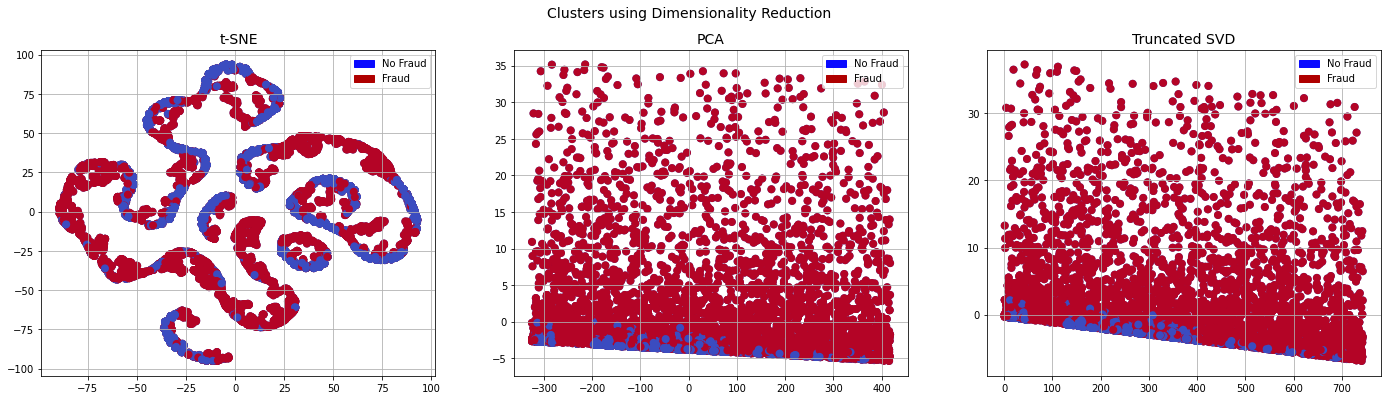

In [18]:
f, (ax1, ax2, ax3,) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch  = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])


# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])


plt.show()

# Classifiers

Summary:

*   Logistic Regression classifier is more accurate than the other three classifiers in most cases (as we will analyze next)
*   GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.
*   Logistic Regression has the best ROC, which means LogisticRegression pretty accurately separates fraud and non-fraud transactions.






In [19]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = new_df['isFraud']

In [20]:
# As data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# this is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# turning the values into an array for feeding to the classification algorithms
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [22]:
# classifiers
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [23]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier has a training score of 91.0 % accuracy score
Classifiers:  SVC has a training score of 73.0 % accuracy score
Classifiers:  DecisionTreeClassifier has a training score of 98.0 % accuracy score


In [24]:
# GridSearchCV ia used to find the best parameters for an estimator
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
LogReg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_LogReg = GridSearchCV(LogisticRegression(), LogReg_params)
grid_LogReg.fit(X_train, y_train)
# Therefore, we automatically get the Logistic Regression estimator with the best parameters
LogReg = grid_LogReg.best_estimator_


# kNN
kNN_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_kNN = GridSearchCV(KNeighborsClassifier(), kNN_params)
grid_kNN.fit(X_train, y_train)
# kNN best estimator
kNN_neighbors = grid_kNN.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# tree best estimator
tree_clf = grid_tree.best_estimator_

In [25]:
# Overfitting Case
LogReg_score = cross_val_score(LogReg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(LogReg_score.mean() * 100, 2).astype(str) + '%')

kNN_score = cross_val_score(kNN_neighbors, X_train, y_train, cv=5)
print('kNN Cross Validation Score', round(kNN_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  95.82%
kNN Cross Validation Score 91.4%
DecisionTree Classifier Cross Validation Score 94.11%


In [26]:
# undersample during cross validating
undersample_X = df.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
undersample_y = df['isFraud']

for train_index, test_index in skf.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest  = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest  = undersample_ytest.values 

undersample_accuracy  = []
undersample_precision = []
undersample_recall    = []
undersample_f1        = []
undersample_auc       = []

# Cross Validating the right way

for train, test in skf.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), LogReg) # SMOTE happens during Cross Validation
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [1272517 1272518 1272519 ... 6362617 6362618 6362619] Test: [      0       1       2 ... 1276120 1277245 1277356]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [1272517 1272518 1272519 ... 2545096 2545097 2545098]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [2503162 2503569 2503605 ... 3817608 3817609 3817610]
Train: [      0       1       2 ... 6362617 6362618 6362619] Test: [3782566 3782746 3783289 ... 5090095 5090096 5090097]
Train: [      0       1       2 ... 5090095 5090096 5090097] Test: [5087683 5089487 5090098 ... 6362617 6362618 6362619]


# Plotting : Learning Curves

*   The wider the gap b/w the training score and the cross validation score, the more likely it is that the model is overfitting (high variance).

*   If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)



NOTE : Just as an example, we are plotting a learning curve for one of the classifiers so as to ensure our classifiers are working fine

In [27]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax = plt.subplots(1, 1, figsize=(20,14), sharey=True)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
    ax.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax.set_xlabel('Training size (m)')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

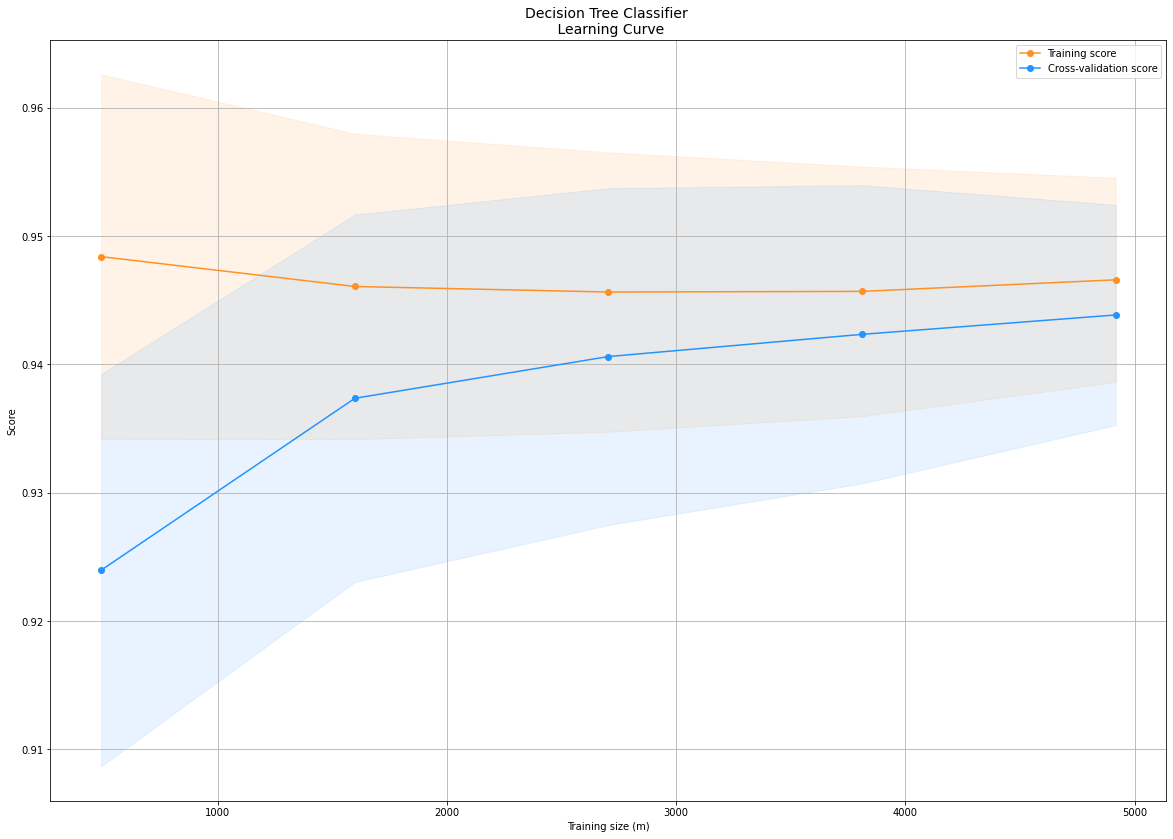

In [28]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [29]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

LogReg_pred = cross_val_predict(LogReg, X_train, y_train, cv=5, method="decision_function")

kNN_pred = cross_val_predict(kNN_neighbors, X_train, y_train, cv=5)

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [30]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, LogReg_pred))
print('KNN Neighbors: ', roc_auc_score(y_train, kNN_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9908478345465164
KNN Neighbors:  0.9091841705743029
Decision Tree Classifier:  0.9166172122594965


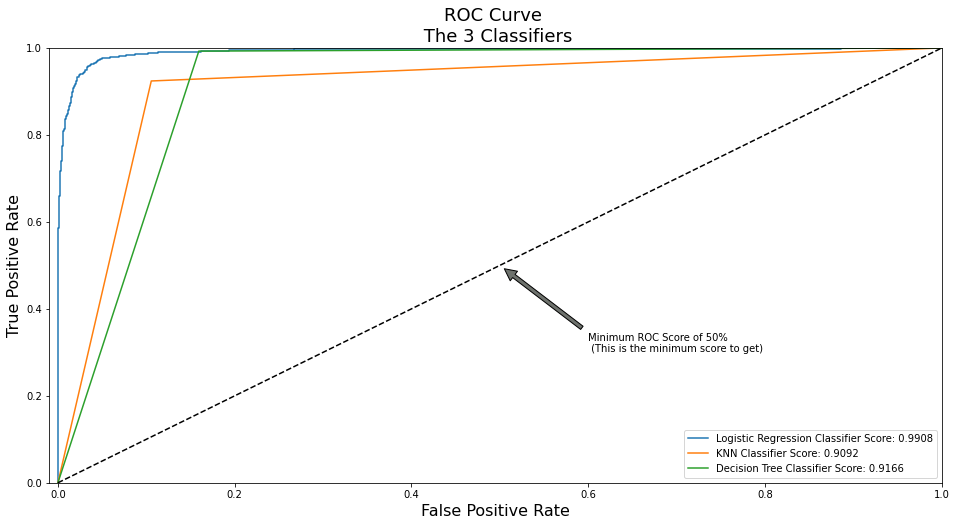

In [31]:
log_fpr, log_tpr, log_thresold        = roc_curve(y_train, LogReg_pred)
kNN_fpr, kNN_tpr, kNN_threshold = roc_curve(y_train, kNN_pred)
tree_fpr, tree_tpr, tree_threshold    = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, kNN_fpr, kNN_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n The 3 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, LogReg_pred)))
    plt.plot(kNN_fpr, kNN_tpr, label='KNN Classifier Score: {:.4f}'.format(roc_auc_score(y_train, kNN_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3), arrowprops=dict(facecolor='#6E726D', shrink=0.05),)
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, kNN_fpr, kNN_tpr, tree_fpr, tree_tpr)
plt.show()